<a href="https://colab.research.google.com/github/matheusro/Uniritter-topicos2-NLP/blob/master/Trabalho_Topicos_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Prático - Processamento de Linguagem Natural
Disciplina: Tópicos II / Professor: William Becker

### Alunos:
Gustavo da Costa Oliveira / Vinícius Valim de Melo / Cláudia Duarte Rodrigues de Oliveira / Matheus Reck de Oliveira

Fonte do Dataset: https://www.kaggle.com/cursostic/avaliao-atendimento#all.csv

Os dados analisados contêm **avaliações de atendimento de equipe de Suporte de TI**.

Neste trabalho iremos realizar uma Análise de Sentimentos (elogio ou reclamação) sobre o nível de atendimento da área frente aos usuários da empresa.

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
import numpy as np
import pandas as pd
dataset = pd.read_excel("all.xlsx")

In [5]:
print(dataset)

                                                  coment manifest_atendimento
0                              Nunca abri esse incidente               neutro
1      Profissionais educados, atenciosos e o mais im...               elogio
2      Não tenho condições de responder a esta pesqui...           reclamação
3      Chamado não foi resolvido. Apesar de explicado...           reclamação
4      O chamado foi encerrado como concluído. Porém,...           reclamação
...                                                  ...                  ...
42309  O problema não foi resolvido, porém foi fornec...               neutro
42310                            Excelente atendimento!!               elogio
42311                              Atendimento perfeito.               elogio
42312  Não foi resolvido por motivos externos, servid...               neutro
42313                   Serviço com atendimento perfeito               elogio

[42314 rows x 2 columns]


Ao descrever o dataset abaixo, percebe-se que existem algumas avaliações de atendimento onde os usuários não fizeram nenhum comentário **(8 casos)**.

Coincidentemente, alguns usuários incluiram exatamente os mesmos comentários na avaliação. No entanto, ainda temos muitos comentários exclusivos, **totalizando 31253**.

O comentário mais reincidente foi o elogio de **"Excelente atendimento."**, sendo apresentado **634 vezes**.

In [0]:
# guarda os comentários puros em um novo campo para realizar um comparativo dos modelos no final
dataset['coment_puro'] = dataset['coment']

In [7]:
print(dataset.describe()) 

                        coment manifest_atendimento             coment_puro
count                    42306                42314                   42306
unique                   31253                    3                   31253
top     Excelente atendimento.               elogio  Excelente atendimento.
freq                       634                27630                     634


Como primeiro ajuste do dataset, removemos os registros que não tiveram nenhum comentário.

In [0]:
# remove os comentarios nulos
dataset = dataset[dataset["coment"].isnull() == False]

In [9]:
print(dataset.describe()) 

                        coment manifest_atendimento             coment_puro
count                    42306                42306                   42306
unique                   31253                    3                   31253
top     Excelente atendimento.               elogio  Excelente atendimento.
freq                       634                27630                     634


Analisando as classes originais do dataset, temos a seguinte distribuição:

In [10]:
print(dataset['manifest_atendimento'].value_counts())

elogio        27630
neutro         8174
reclamação     6502
Name: manifest_atendimento, dtype: int64


Para simplificar o modelo, vamos trabalhar somente com duas categorias (elogio e reclamação). Neste caso, iremos considerar que todas avaliações neutras também são reclamação.

In [0]:
# considera todas avaliações neutras como reclamação para equilibrar a amostragem entre 'elogio' X 'reclamação'
dataset.loc[dataset.manifest_atendimento == 'neutro', 'manifest_atendimento'] = 'reclamação'

In [12]:
print(dataset['manifest_atendimento'].value_counts())

elogio        27630
reclamação    14676
Name: manifest_atendimento, dtype: int64


Abaixo, nós convertemos os tipos de dado dos campos 'coment' para 'str' e 'manifest_atendimento' para 'category'.

In [0]:
# converte os comentarios para string
dataset['coment'] = dataset.coment.astype(str)
dataset['coment_puro'] = dataset.coment.astype(str)
# converte os manifestos para categorico
dataset['manifest_atendimento'] = dataset.manifest_atendimento.astype('category')

A seguir, iniciamos alguns tratamentos específicos do campo 'coment', como por exemplo a tokenização e a limpeza de caracteres especiais.

In [0]:
def removerAcentosECaracteresEspeciais(palavra):

    # Unicode normalize transforma um caracter em seu equivalente em latin.
    nfkd = unicodedata.normalize('NFKD', palavra)
    palavraSemAcento = u"".join([c for c in nfkd if not unicodedata.combining(c)])

    # Usa expressão regular para retornar a palavra apenas com números, letras e espaço
    return re.sub('[^a-zA-Z0-9 \\\]', '', palavraSemAcento)

In [15]:
import nltk
import unicodedata
import re
# importa tokenizadores e stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# realiza a limpeza nos dados (lowercase e remocao de caracteres)
replace_espaco = re.compile('[/(){}\[\]\|@,;]')

def pre_processamento(text):
    text = text.lower()
    text = replace_espaco.sub(' ', text)
    return text

dataset['coment'] = dataset['coment'].apply(pre_processamento)
dataset['coment'] = dataset['coment'].apply(removerAcentosECaracteresEspeciais)

In [17]:
print(dataset)

                                                  coment  ...                                        coment_puro
0                              nunca abri esse incidente  ...                          Nunca abri esse incidente
1      profissionais educados  atenciosos e o mais im...  ...  Profissionais educados, atenciosos e o mais im...
2      nao tenho condicoes de responder a esta pesqui...  ...  Não tenho condições de responder a esta pesqui...
3      chamado nao foi resolvido apesar de explicado ...  ...  Chamado não foi resolvido. Apesar de explicado...
4      o chamado foi encerrado como concluido porem  ...  ...  O chamado foi encerrado como concluído. Porém,...
...                                                  ...  ...                                                ...
42309  o problema nao foi resolvido  porem foi fornec...  ...  O problema não foi resolvido, porém foi fornec...
42310                              excelente atendimento  ...                            Excelen

**Tokenização** de cada um dos comentários:

In [18]:
# preparacao dos dados
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# tokenizando as sentencas
dataset["coment"] = [word_tokenize(word) for word in dataset["coment"]]
print(dataset)

                                                  coment  ...                                        coment_puro
0                         [nunca, abri, esse, incidente]  ...                          Nunca abri esse incidente
1      [profissionais, educados, atenciosos, e, o, ma...  ...  Profissionais educados, atenciosos e o mais im...
2      [nao, tenho, condicoes, de, responder, a, esta...  ...  Não tenho condições de responder a esta pesqui...
3      [chamado, nao, foi, resolvido, apesar, de, exp...  ...  Chamado não foi resolvido. Apesar de explicado...
4      [o, chamado, foi, encerrado, como, concluido, ...  ...  O chamado foi encerrado como concluído. Porém,...
...                                                  ...  ...                                                ...
42309  [o, problema, nao, foi, resolvido, porem, foi,...  ...  O problema não foi resolvido, porém foi fornec...
42310                           [excelente, atendimento]  ...                            Excelen

Aplicamos em seguida a remoção de **stopwords** da língua portuguesa e **stemming** sobre as palavras para obtenção dos radicais, guardando-as no campo **'coment_stem'**:

In [0]:
# remocao de stopwords
dataset["coment_stopwords"] = dataset["coment"].apply(lambda x: [item for item in x if item not in stopwords.words("portuguese")])

In [20]:
print(dataset)

                                                  coment  ...                                   coment_stopwords
0                         [nunca, abri, esse, incidente]  ...                           [nunca, abri, incidente]
1      [profissionais, educados, atenciosos, e, o, ma...  ...  [profissionais, educados, atenciosos, importan...
2      [nao, tenho, condicoes, de, responder, a, esta...  ...  [nao, condicoes, responder, pesquisa, onde, pa...
3      [chamado, nao, foi, resolvido, apesar, de, exp...  ...  [chamado, nao, resolvido, apesar, explicado, n...
4      [o, chamado, foi, encerrado, como, concluido, ...  ...  [chamado, encerrado, concluido, porem, ramal, ...
...                                                  ...  ...                                                ...
42309  [o, problema, nao, foi, resolvido, porem, foi,...  ...  [problema, nao, resolvido, porem, fornecido, o...
42310                           [excelente, atendimento]  ...                           [excelen

In [21]:
# Tratar as palavras para obter somente radicais - STEMMING
import nltk
nltk.download('rslp')
from nltk.stem import RSLPStemmer

def Stemming(sentence):
    stemmer = RSLPStemmer()
    phrase = []
    for word in sentence:
        phrase.append(stemmer.stem(word.lower()))
    return phrase

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


In [22]:
# Cria coluna nova com os radicais das palavras
# Guarda coment com stopwords + stemming
dataset['coment_stem'] = dataset['coment_stopwords'].apply(Stemming)
print(dataset)

                                                  coment  ...                                        coment_stem
0                         [nunca, abri, esse, incidente]  ...                                 [nunc, abr, incid]
1      [profissionais, educados, atenciosos, e, o, ma...  ...  [profiss, educ, atenci, import, problem, resol...
2      [nao, tenho, condicoes, de, responder, a, esta...  ...  [nao, condico, respond, pesquis, ond, parec, p...
3      [chamado, nao, foi, resolvido, apesar, de, exp...  ...  [cham, nao, resolv, apes, explic, necess, priv...
4      [o, chamado, foi, encerrado, como, concluido, ...  ...  [cham, encerr, conclu, por, ramal, continu, co...
...                                                  ...  ...                                                ...
42309  [o, problema, nao, foi, resolvido, porem, foi,...  ...  [problem, nao, resolv, por, fornec, orientaco,...
42310                           [excelente, atendimento]  ...                                   

A seguir é apresentado um ranking das palavras mais frequentes nos comentários, onde percebemos que a mais mencionada foi o radical **'atend'**, sendo exibida mais de **25000 vezes**.

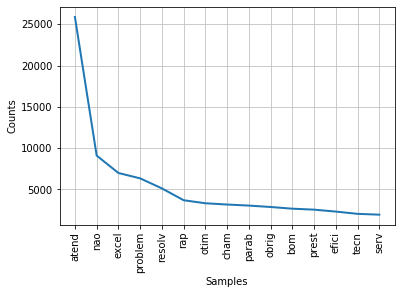

In [23]:
from nltk.probability import FreqDist
fdist = FreqDist()
for word in dataset['coment_stem']:
    for token in word:      
        fdist[token] += 1
fdist.plot(15)

Para entender melhor a distribuição das palavras frequentes, geramos duas visões de nuvem de palavras, sendo a primeira dos 'elogios' e a segunda das 'reclamações'.

In [0]:
#pip install wordcloud
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

In [25]:
# Juntamos os tokens para a geração das nuvens e para a realização do treino dos modelos
dataset["coment"] = [' '.join(word) for word in dataset["coment"]]
dataset["coment_stopwords"] = [' '.join(word) for word in dataset["coment_stopwords"]]
dataset["coment_stem"] = [' '.join(word) for word in dataset["coment_stem"]]
print(dataset)

                                                  coment  ...                                        coment_stem
0                              nunca abri esse incidente  ...                                     nunc abr incid
1      profissionais educados atenciosos e o mais imp...  ...  profiss educ atenci import problem resolv prof...
2      nao tenho condicoes de responder a esta pesqui...  ...  nao condico respond pesquis ond parec promet a...
3      chamado nao foi resolvido apesar de explicado ...  ...  cham nao resolv apes explic necess privilegi a...
4      o chamado foi encerrado como concluido porem o...  ...  cham encerr conclu por ramal continu const con...
...                                                  ...  ...                                                ...
42309  o problema nao foi resolvido porem foi forneci...  ...  problem nao resolv por fornec orientaco necess...
42310                              excelente atendimento  ...                                   

In [0]:
def nuvem_palavras(dataset):

    comment_words = ''  
    stopwords = set(STOPWORDS)

    for i in range(0, len(dataset)):
        val = dataset.iloc[i]['coment']
        tokens = val.split() 
      
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
              
        for words in tokens: 
            comment_words = comment_words + words + ' '

    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
      
    plt.show() 

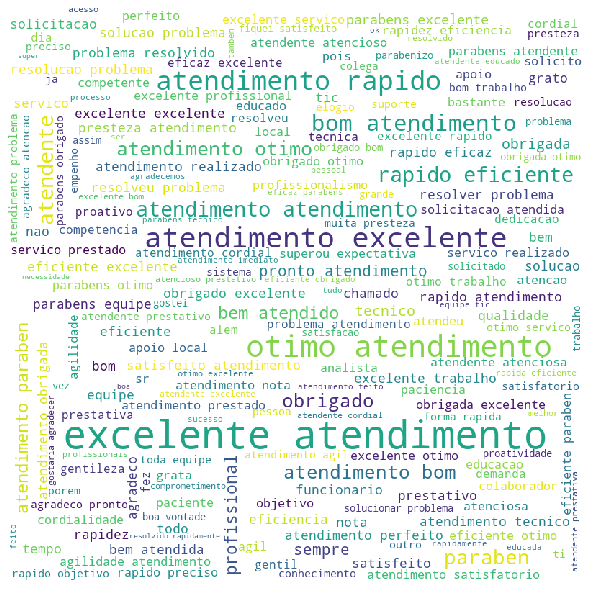

In [27]:
elogios = dataset[dataset['manifest_atendimento']=='elogio']
elogios.coment = elogios.coment_stopwords
nuvem_palavras(elogios)

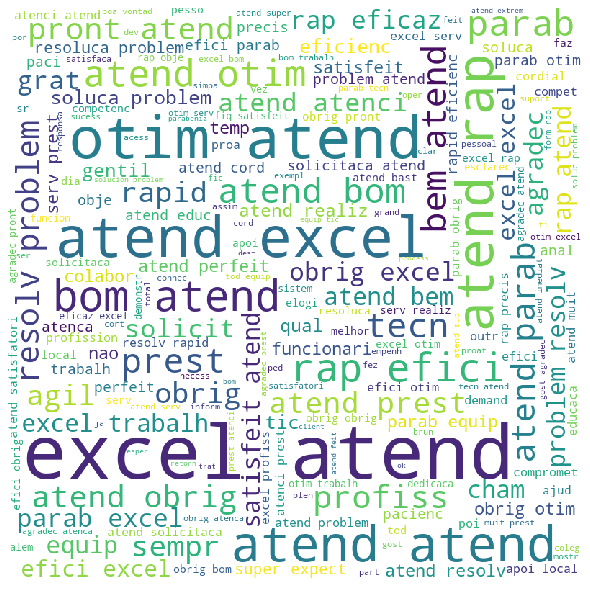

In [28]:
# visão dos elogios somente com os radicais
elogios.coment = elogios.coment_stem
nuvem_palavras(elogios)

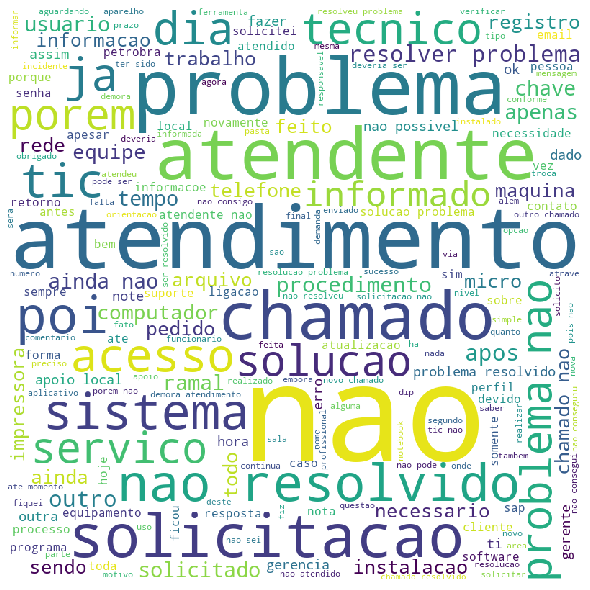

In [29]:
reclamacoes = dataset[dataset['manifest_atendimento']=='reclamação']
reclamacoes.coment = reclamacoes.coment_stopwords
nuvem_palavras(reclamacoes)

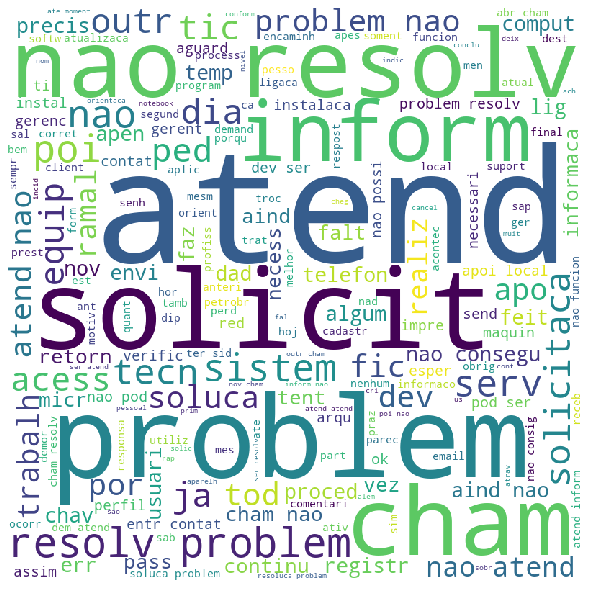

In [30]:
# visão das reclamações somente com os radicais
reclamacoes.coment = reclamacoes.coment_stem
nuvem_palavras(reclamacoes)

Após as análises e preparação dos dados, começamos a treinar nossos modelos Naive Bayes e SVM.

In [0]:
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score
from sklearn import svm

In [0]:
def nb_model(X, Y):

    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, 
                                                                        Y, 
                                                                        test_size=0.3)
    Encoder = LabelEncoder()
    y_train = Encoder.fit_transform(y_train)
    y_test = Encoder.fit_transform(y_test)

    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(X)
    Train_X_Tfidf = Tfidf_vect.transform(X_train)
    Test_X_Tfidf = Tfidf_vect.transform(X_test)

    Naive = naive_bayes.MultinomialNB()
    Naive.fit(Train_X_Tfidf, y_train)

    predictions_NB = Naive.predict(Test_X_Tfidf)

    result = accuracy_score(predictions_NB, y_test)*100

    return result

In [33]:
print("Acuracia NB:", nb_model(dataset["coment_stem"],dataset["manifest_atendimento"]))

Acuracia NB: 92.34163252442484


In [0]:
def svm_model(X, Y):

    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, 
                                                                        Y, 
                                                                        test_size=0.3)
    Encoder = LabelEncoder()
    y_train = Encoder.fit_transform(y_train)
    y_test = Encoder.fit_transform(y_test)

    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(X)
    Train_X_Tfidf = Tfidf_vect.transform(X_train)
    Test_X_Tfidf = Tfidf_vect.transform(X_test)

    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    SVM.fit(Train_X_Tfidf, y_train)

    predictions_SVM = SVM.predict(Test_X_Tfidf)

    result = accuracy_score(predictions_SVM, y_test)*100

    return result

In [35]:
print("Acuracia SVM:", svm_model(dataset["coment_stem"],dataset["manifest_atendimento"]))

Acuracia SVM: 93.35014182161991


Comparando as acurácias dos modelos Naive Bayes e SVM aplicados aos comentários com todos os tratamentos de remoção de caracrteres especiais, remoção de stopwords e aplicação de stemming com os comentários utilizados puros, ou seja, sem nenhum tratamento, percebemos que os resultados ficaram muito próximos.

In [36]:
print("Acuracia NB:", nb_model(dataset["coment_puro"],dataset["manifest_atendimento"]))

Acuracia NB: 92.40466435549952


In [37]:
print("Acuracia SVM:", svm_model(dataset["coment_puro"],dataset["manifest_atendimento"]))

Acuracia SVM: 93.53923731484399


In [0]:
# INCLUIR UM TESTE DO MODELO 
## Inventar um ELOGIO e uma RECLAMAÇÃO